| Etapa                      | Tecnologia recomendada                              | Justificativa                                           |
| -------------------------- | --------------------------------------------------- | ------------------------------------------------------- |
| Orquestração mensal        | `cron` no App Service ou Azure Functions            | Automação simples                                       |
| Ambiente isolado           | Docker                                              | Facilita dependências (`duckdb`, `pandas`, `azure-sdk`) |
| Extração + Upload Bronze   | Python puro (`requests`, `zipfile`, `DataLake SDK`) | Você já faz isso bem                                    |
| Transformações Silver/Gold | `Pandas` ou `DuckDB`                                | Leves, simples, ideais para CSV                         |
| Deploy                     | Azure App Service + GitHub Actions                  | CI/CD automatizado                                      |


cnes-data-pipeline/
│
├── Dockerfile
├── requirements.txt
├── app.py                  ← ponto de entrada principal
├── extract/
│   └── extract_cnes.py     ← download e bronze upload
├── transform/
│   ├── silver.py           ← limpeza e joins
│   └── gold.py             ← agregações e finais
├── utils/
│   └── azure_datalake.py   ← funções para leitura/escrita
└── cron/
    └── crontab.txt         ← para rodar mensalmente no container


# Conexão com o Datalake

In [371]:
from azure.storage.filedatalake import DataLakeServiceClient
from io import BytesIO
import os
import pandas as pd

# =========================
# Conexão
# =========================
ACCOUNT_NAME = "cnesstorage"
ACCOUNT_KEY  = os.getenv("AZURE_STORAGE_KEY", "/ae47eZuE0NGPopxVHEkxOKsQwtEm3qQM0vBRPBRbB5nAW1zO6FPkEO9gwNQwkqExaVhOyHWgb68+AStIau+Uw==")
FILE_SYSTEM  = "gold"

service_client = DataLakeServiceClient(
    account_url=f"https://{ACCOUNT_NAME}.dfs.core.windows.net",
    credential=ACCOUNT_KEY,
)
fs = service_client.get_file_system_client(FILE_SYSTEM)


def read_from_adls(
    fs_client,
    path: str,
    file_type: str | None = None,
    **kwargs
) -> pd.DataFrame:
    """
    Lê um arquivo do ADLS em memória e carrega em um DataFrame Pandas.

    Params:
      fs_client : FileSystemClient do ADLS
      path      : caminho no container (ex: 'estabelecimentos_202501.parquet')
      file_type : 'parquet' | 'csv' | 'json' | None (quando None, infere pela extensão)
      **kwargs  : repassados ao reader correspondente (sep, encoding, dtype, nrows, etc.)

    Ex.: read_from_adls(fs, "dados.parquet")
         read_from_adls(fs, "dados.csv", sep=";", encoding="utf-8")
         read_from_adls(fs, "dados.json", lines=True)
    """
    # Inferência simples pela extensão, caso não venha file_type
    if file_type is None:
        lower = path.lower()
        if lower.endswith(".parquet"):
            file_type = "parquet"
        elif lower.endswith(".csv"):
            file_type = "csv"
        elif lower.endswith(".json"):
            file_type = "json"
        else:
            raise ValueError("Cannot infer file_type from extension. Pass file_type explicitly.")

    file_client = fs_client.get_file_client(path)
    data = file_client.download_file().readall()
    bio = BytesIO(data)

    if file_type == "parquet":
        return pd.read_parquet(bio, **kwargs)
    elif file_type == "csv":
        return pd.read_csv(bio, **kwargs)
    elif file_type == "json":
        return pd.read_json(bio, **kwargs)
    else:
        raise ValueError(f"Unsupported file_type: {file_type!r}. Use 'parquet', 'csv' or 'json'.")


df_populacao = read_from_adls(fs, "populacao/populacao_sp/data.parquet", file_type="parquet")
df_estabelecimentos = read_from_adls(fs, "estabelecimentos/estabelecimentos_sp/data.parquet", file_type="parquet")
df_populacao.head()

,DATE,POPULACAO_MENSAL,MM,YYYY,CO_MUNICIPIO,NO_MUNICIPIO,CO_UF,NO_UF,NO_REGIAO,CO_MUNICIPIO_COMPLETO,NO_MUNICIPIO_IBGE,CO_MUNICIPIO_SEM_DIGITO,IMPUTED,POPULACAO,GROWTH_ABS,GROWTH_PCT
0,2011-01-01,4979,1,2011,758.0,Alambari,35.0,São Paulo,Sorocaba,3500758.0,ALAMBARI,350075,False,4979,<NA>,<NA>
1,2011-02-01,4987,2,2011,758.0,Alambari,35.0,São Paulo,Sorocaba,3500758.0,ALAMBARI,350075,False,4979,8,0.001607
2,2011-03-01,4994,3,2011,758.0,Alambari,35.0,São Paulo,Sorocaba,3500758.0,ALAMBARI,350075,False,4979,7,0.001404
3,2011-04-01,5002,4,2011,758.0,Alambari,35.0,São Paulo,Sorocaba,3500758.0,ALAMBARI,350075,False,4979,8,0.001602
4,2011-05-01,5009,5,2011,758.0,Alambari,35.0,São Paulo,Sorocaba,3500758.0,ALAMBARI,350075,False,4979,7,0.001399


In [373]:
df_estabelecimentos.query("NO_MUNICIPIO_IBGE == 'SAO CARLOS' and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head(5)

,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000
72108,354890,SAO CARLOS,MEDICO CARDIOLOGISTA,2022,1,50,35.0,São Paulo,Araraquara,SAO CARLOS,259678,259678.0,236,0.00091,0.192546
72109,354890,SAO CARLOS,MEDICO CARDIOLOGISTA,2022,2,50,35.0,São Paulo,Araraquara,SAO CARLOS,259914,259678.0,236,0.000909,0.192371
72110,354890,SAO CARLOS,MEDICO CARDIOLOGISTA,2022,3,49,35.0,São Paulo,Araraquara,SAO CARLOS,260127,259678.0,213,0.00082,0.18837
72111,354890,SAO CARLOS,MEDICO CARDIOLOGISTA,2022,4,49,35.0,São Paulo,Araraquara,SAO CARLOS,260364,259678.0,237,0.000911,0.188198
72112,354890,SAO CARLOS,MEDICO CARDIOLOGISTA,2022,5,54,35.0,São Paulo,Araraquara,SAO CARLOS,260593,259678.0,229,0.00088,0.20722


## Plot Functions

In [209]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_prof_per_1k_over_time(df_final: pd.DataFrame, city: str):
    # cria coluna de data
    df = df_final.copy()
    df["date"] = pd.to_datetime(df["YYYY"].astype(str) + "-" + df["MM"].astype(str).str.zfill(2) + "-01")

    # filtra cidade
    df = df[df["NO_MUNICIPIO"].str.upper().str.strip() == city.upper().strip()]
    if df.empty:
        print(f"Sem dados para {city}.")
        return

    # pivot: linhas = data, colunas = especialidade, valores = profissionais por 1000
    pivot = (
        df.pivot_table(
            index="date",
            columns="DS_ATIVIDADE_PROFISSIONAL",
            values="PROFISSIONAIS_POR_1000",
            aggfunc="mean"
        )
        .sort_index()
    )

    # plota
    ax = pivot.plot(figsize=(12, 6))
    ax.set_title(f"Profissionais por 1.000 hab — {city.upper()}")
    ax.set_xlabel("Data")
    ax.set_ylabel("Profissionais por 1.000")
    ax.legend(title="Especialidade", ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_population_over_time(df: pd.DataFrame, city: str, *, city_col="NO_MUNICIPIO"):
    d = df.copy()

    # build monthly date safely
    d["YYYY"] = pd.to_numeric(d["YYYY"], errors="coerce").astype("Int64")
    d["MM"]   = pd.to_numeric(d["MM"],   errors="coerce").astype("Int64")
    d = d.dropna(subset=["YYYY","MM"])
    d["date"] = pd.to_datetime(
        d["YYYY"].astype(int).astype(str) + "-" +
        d["MM"].astype(int).astype(str).str.zfill(2) + "-01"
    )

    # filter city (case/space-insensitive)
    mask_city = d[city_col].str.upper().str.strip() == city.upper().strip()
    d = d[mask_city]
    if d.empty:
        print(f"Sem dados de população para {city}.")
        return

    # choose the population column
    pop_col = "POPULACAO_MENSAL" if "POPULACAO_MENSAL" in d.columns else "POPULACAO"

    # monthly series: if multiple rows per month, take the max (avoids duplicates by especialidade)
    pop_mensal = (
        d.groupby("date")[pop_col]
         .max()
         .sort_index()
    )

    # plot
    ax = pop_mensal.plot(figsize=(12, 4))
    ax.set_title(f"População — {city.upper()}")
    ax.set_xlabel("Data")
    ax.set_ylabel("População")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


from typing import Optional

def plot_city_prof1k_and_population(
    df: pd.DataFrame,
    city: str,
    *,
    city_col: str = "NO_MUNICIPIO",
    year_col: str = "YYYY",
    month_col: str = "MM",
    date_col: str = "date",
    specialty_col: str = "DS_ATIVIDADE_PROFISSIONAL",
    idx_col: str = "PROFISSIONAIS_POR_1000",
    pop_monthly_col: str = "POPULACAO_MENSAL",
    pop_yearly_col: str = "POPULACAO",
    top_n_specialties: Optional[int] = None,  # e.g. 6 to keep legend short
    fig_w: float = 16,
    fig_h: float = 5,
    legend_fontsize: int = 8,
    legend_title: str = "Especialidade",
    xtick_rotation: int = 30
) -> None:
    """
    Plots two side-by-side charts for a city:
      - Left: Profissionais por 1.000 hab (one line per specialty; legend outside)
      - Right: População mensal

    If POPULACAO_MENSAL is not present, falls back to POPULACAO (yearly) and takes max per month.
    Set top_n_specialties to limit the number of lines (by highest mean value).
    """

    d = df.copy()

    # Build monthly date safely
    if date_col not in d.columns:
        d[year_col]  = pd.to_numeric(d[year_col],  errors="coerce").astype("Int64")
        d[month_col] = pd.to_numeric(d[month_col], errors="coerce").astype("Int64")
        d = d.dropna(subset=[year_col, month_col])
        d[date_col] = pd.to_datetime(
            d[year_col].astype(int).astype(str) + "-" +
            d[month_col].astype(int).astype(str).str.zfill(2) + "-01"
        )

    # Filter city (case/space-insensitive)
    d = d[d[city_col].str.upper().str.strip() == city.upper().strip()]
    if d.empty:
        print(f"Sem dados para {city}.")
        return

    # Left panel data: pivot index=month date, columns=specialty, values=index
    left_df = (
        d.pivot_table(
            index=date_col,
            columns=specialty_col,
            values=idx_col,
            aggfunc="mean"
        )
        .sort_index()
    )

    # Optionally keep only top-N specialties by mean value (for a cleaner legend)
    if top_n_specialties is not None and top_n_specialties > 0 and not left_df.empty:
        keep_cols = (
            left_df.mean(skipna=True)
                   .sort_values(ascending=False)
                   .head(top_n_specialties)
                   .index
        )
        left_df = left_df[keep_cols]

    # Right panel data: population monthly (or yearly fallback)
    pop_col = pop_monthly_col if pop_monthly_col in d.columns else pop_yearly_col
    right_s = (
        d.groupby(date_col)[pop_col]
         .max()      # avoid duplicates by specialty
         .sort_index()
    )

    # ---- Plot side-by-side with outside legend (left) ----
    fig, axes = plt.subplots(1, 2, figsize=(fig_w, fig_h), constrained_layout=True)

    # Left: index per 1k
    left_lines = left_df.plot(ax=axes[0])  # returns Axes
    axes[0].set_title(f"Profissionais por 1.000 hab — {city.upper()}")
    axes[0].set_xlabel("Data")
    axes[0].set_ylabel("Profissionais por 1.000")
    axes[0].grid(True)

    # Legend outside (to the right of left subplot)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(
        handles, labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        fontsize=legend_fontsize,
        title=legend_title
    )

    # Right: population
    right_s.plot(ax=axes[1])
    axes[1].set_title(f"População — {city.upper()}")
    axes[1].set_xlabel("Data")
    axes[1].set_ylabel("População")
    axes[1].grid(True)

    # Rotate x-ticks for both panels
    for ax in axes:
        ax.tick_params(axis="x", rotation=xtick_rotation)

    plt.show()


In [375]:
df_estabelecimentos.query("NO_MUNICIPIO_IBGE == 'INDAIATUBA' and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head(10)

,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000
17366,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,1,20,35.0,São Paulo,Campinas,INDAIATUBA,263037,263037.0,200,0.000761,0.076035
17367,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,2,20,35.0,São Paulo,Campinas,INDAIATUBA,263237,263037.0,200,0.00076,0.075977
17368,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,3,21,35.0,São Paulo,Campinas,INDAIATUBA,263418,263037.0,181,0.000688,0.079721
17369,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,4,20,35.0,São Paulo,Campinas,INDAIATUBA,263619,263037.0,201,0.000763,0.075867
17370,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,5,20,35.0,São Paulo,Campinas,INDAIATUBA,263814,263037.0,195,0.00074,0.075811
17371,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,6,21,35.0,São Paulo,Campinas,INDAIATUBA,264014,263037.0,200,0.000758,0.079541
17372,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,7,21,35.0,São Paulo,Campinas,INDAIATUBA,264209,263037.0,195,0.000739,0.079483
17373,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,8,20,35.0,São Paulo,Campinas,INDAIATUBA,264410,263037.0,201,0.000761,0.07564
17374,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,9,21,35.0,São Paulo,Campinas,INDAIATUBA,264612,263037.0,202,0.000764,0.079361
17375,352050,INDAIATUBA,MEDICO CARDIOLOGISTA,2022,10,21,35.0,São Paulo,Campinas,INDAIATUBA,264807,263037.0,195,0.000737,0.079303


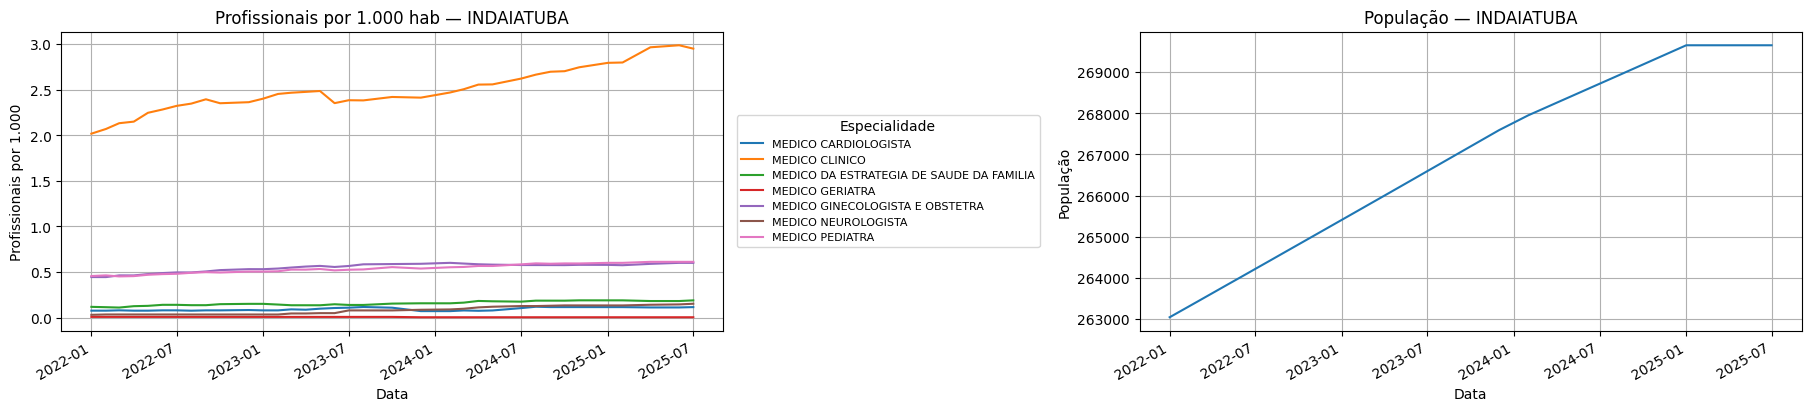

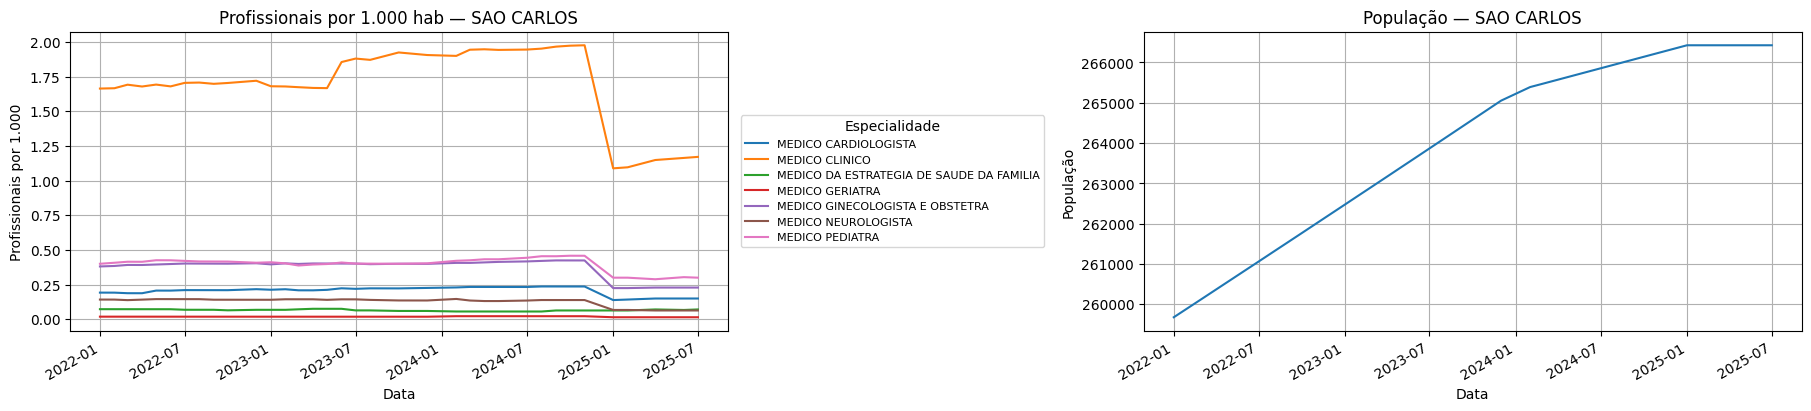

In [376]:
# plot_prof_per_1k_over_time(df_estabelecimentos, city="Sao Carlos")
# plot_population_over_time(df_estabelecimentos, city="Sao Carlos")

plot_city_prof1k_and_population(df_estabelecimentos, city="Indaiatuba", fig_w=18, fig_h=4)
plot_city_prof1k_and_population(df_estabelecimentos, city="Sao Carlos", fig_w=18, fig_h=4)


# Modelo


In [377]:
# =========================================================
# Modelos a serem testados
# ---------------------------------------------------------
# 1) Classificação (deficit vs não deficit)
#    Prós:
#    - Simples de interpretar (gestores entendem "vai faltar ou não?")
#    - Bom para alertas e priorização de municípios
#    Contras:
#    - Perde granularidade (não diz quanto vai faltar)
#    - Threshold (p.ex. percentil 25) é arbitrário e pode enviesar

# 2) Forecasting (valor contínuo da disponibilidade futura)
#    Prós:
#    - Mais detalhado (prevê a razão profissionais/1000 habitantes)
#    - Permite planejar alocação mais precisa (quantos médicos serão necessários)
#    Contras:
#    - Mais sensível a ruídos (população flutua, registros podem ser instáveis)
#    - Métricas como RMSE são menos intuitivas para decisão prática
# =========================================================


###  Variavel alvo

In [378]:
import pandas as pd

#Limiar de referência -> percentil 25 da distribuição estadual
threshold = 2# df_estabelecimentos["PROFISSIONAIS_POR_1000"].quantile(0.25)

df_estabelecimentos["deficit"] = (
    df_estabelecimentos["PROFISSIONAIS_POR_1000"] < threshold
).astype(int)


### Fatures úteis
- População absoluta: POPULACAO_MENSAL
- Taxa de crescimento: GROWTH_PCT
- Histórico curto: rolling mean ou lag dos últimos 3 meses:

In [379]:
import pandas as pd
import numpy as np

# =========================================================
# 2. Preparação de data + ordenação
# =========================================================
df_estabelecimentos["date"] = pd.to_datetime(
    df_estabelecimentos["YYYY"].astype(str) + "-" + df_estabelecimentos["MM"].astype(str).str.zfill(2) + "-01"
)

# Ordena por chave temporal dentro de cada município+especialidade
df_estabelecimentos = df_estabelecimentos.sort_values(
    ["CO_MUNICIPIO_SEM_DIGITO", "DS_ATIVIDADE_PROFISSIONAL", "date"],
    kind="stable"
)

# =========================================================
# 3. Alvos e rótulos
# =========================================================
# (A) threshold por ESPECIALIDADE (p25)
threshold_by_spec = (
    df_estabelecimentos
    .groupby("DS_ATIVIDADE_PROFISSIONAL")["PROFISSIONAIS_POR_1000"]
    .transform(lambda s: s.quantile(0.25))
)

# (B) Déficit do MÊS ATUAL (nullable int)
df_estabelecimentos["deficit"] = (
    df_estabelecimentos["PROFISSIONAIS_POR_1000"] < threshold_by_spec
).astype("Int64")

# (C) Target para forecasting = valor do mês seguinte (respeitando a ordem)
df_estabelecimentos["target_next_month"] = (
    df_estabelecimentos
      .groupby(["CO_MUNICIPIO_SEM_DIGITO", "DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"]
      .shift(-1)
)

# (D) Déficit do PRÓXIMO mês (classificação futura) — preserva NaN no fim da série
df_estabelecimentos["deficit_next"] = (
    (df_estabelecimentos["target_next_month"] < threshold_by_spec)
    # mantém NaN onde não há target_next_month
    .where(~df_estabelecimentos["target_next_month"].isna())
    # converte booleano com NA -> inteiro 0/1 com NA
    .astype("boolean")
    .astype("Int64")
)




df_estabelecimentos.query("NO_MUNICIPIO_IBGE == 'SOROCABA' and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head(5)

,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,POPULACAO_MENSAL,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000,deficit,date,target_next_month,deficit_next
78621,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,1,117,35.0,São Paulo,Sorocaba,SOROCABA,715450,715450.0,1731,0.002425,0.163533,0,2022-01-01,0.164532,0
78622,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,2,118,35.0,São Paulo,Sorocaba,SOROCABA,717186,715450.0,1736,0.002426,0.164532,0,2022-02-01,0.16139,0
78623,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,3,116,35.0,São Paulo,Sorocaba,SOROCABA,718757,715450.0,1571,0.002191,0.16139,0,2022-03-01,0.162387,0
78624,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,4,117,35.0,São Paulo,Sorocaba,SOROCABA,720501,715450.0,1744,0.002426,0.162387,0,2022-04-01,0.166161,0
78625,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,5,120,35.0,São Paulo,Sorocaba,SOROCABA,722192,715450.0,1691,0.002347,0.166161,0,2022-05-01,0.162996,0


In [380]:
# =========================================================
# 4. Feature Engineering (corrigido)
# =========================================================

# Garanta a ordenação temporal por município + especialidade + data
df_estabelecimentos = df_estabelecimentos.sort_values(
    ["CO_MUNICIPIO_SEM_DIGITO", "DS_ATIVIDADE_PROFISSIONAL", "date"],
    kind="stable"
)

# LAG de 1 mês (valor do mês anterior no mesmo município/especialidade)
df_estabelecimentos["lag1"] = (
    df_estabelecimentos
      .groupby(["CO_MUNICIPIO_SEM_DIGITO", "DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"]
      .shift(1)
)

# Média móvel de 3 meses alinhada ao índice original (evita MultiIndex do rolling+groupby)
df_estabelecimentos["rolling3"] = (
    df_estabelecimentos
      .groupby(["CO_MUNICIPIO_SEM_DIGITO", "DS_ATIVIDADE_PROFISSIONAL"])["PROFISSIONAIS_POR_1000"]
      .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)
df_estabelecimentos.query("NO_MUNICIPIO_IBGE == 'SOROCABA' and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head(5)

,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,...,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000,deficit,date,target_next_month,deficit_next,lag1,rolling3
78621,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,1,117,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1731,0.002425,0.163533,0,2022-01-01,0.164532,0,<NA>,0.163533
78622,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,2,118,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1736,0.002426,0.164532,0,2022-02-01,0.16139,0,0.163533,0.164033
78623,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,3,116,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1571,0.002191,0.16139,0,2022-03-01,0.162387,0,0.164532,0.163152
78624,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,4,117,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1744,0.002426,0.162387,0,2022-04-01,0.166161,0,0.16139,0.162770
78625,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,5,120,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1691,0.002347,0.166161,0,2022-05-01,0.162996,0,0.162387,0.163313


In [381]:
# =========================================================
# Opcional: transformar NO_REGIAO em dummies
# ---------------------------------------------------------
# Prós:
# - Captura diferenças estruturais entre regiões (ex.: Campinas x Sorocaba)
# - Pode aumentar a acurácia do modelo em contextos específicos
# Contras:
# - Aumenta número de variáveis (risco de overfitting se poucas observações)
# - Modelo pode memorizar "atalhos" regionais em vez de usar tendências gerais
# - Menos generalizável para regiões/municípios fora do treino
# =========================================================

# =========================================================
# 5. Seleção de features
# =========================================================
use_regiao = False  # mude para False para rodar sem NO_REGIAO

if use_regiao:
    df_estabelecimentos = pd.get_dummies(df_estabelecimentos, columns=["NO_REGIAO"], drop_first=True)

# monta lista de features
features = ["POPULACAO_MENSAL", "GROWTH_PCT", "lag1", "rolling3"]
if use_regiao:
    features += [col for col in df_estabelecimentos.columns if col.startswith("NO_REGIAO_")]
    
df_estabelecimentos.query("NO_MUNICIPIO_IBGE == 'SOROCABA' and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head(5)

,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,...,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000,deficit,date,target_next_month,deficit_next,lag1,rolling3
78621,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,1,117,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1731,0.002425,0.163533,0,2022-01-01,0.164532,0,<NA>,0.163533
78622,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,2,118,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1736,0.002426,0.164532,0,2022-02-01,0.16139,0,0.163533,0.164033
78623,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,3,116,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1571,0.002191,0.16139,0,2022-03-01,0.162387,0,0.164532,0.163152
78624,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,4,117,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1744,0.002426,0.162387,0,2022-04-01,0.166161,0,0.16139,0.162770
78625,355220,SOROCABA,MEDICO CARDIOLOGISTA,2022,5,120,35.0,São Paulo,Sorocaba,SOROCABA,...,715450.0,1691,0.002347,0.166161,0,2022-05-01,0.162996,0,0.162387,0.163313


## Cenário para o Executar Modelo

In [382]:
MUNICIPIO = "SANTO ANDRE"
ESPECIALIDADE = "MEDICO CLINICO"

df_model = df_estabelecimentos.query(
    f"NO_MUNICIPIO_IBGE == '{MUNICIPIO}' and DS_ATIVIDADE_PROFISSIONAL == '{ESPECIALIDADE}'"
).dropna(subset=features + ["deficit","target_next_month"])
df_model.head(3)

,CO_MUNICIPIO_SEM_DIGITO,NO_MUNICIPIO,DS_ATIVIDADE_PROFISSIONAL,YYYY,MM,TOTAL_PROFISSIONAIS,CO_UF,NO_UF,NO_REGIAO,NO_MUNICIPIO_IBGE,...,POPULACAO,GROWTH_ABS,GROWTH_PCT,PROFISSIONAIS_POR_1000,deficit,date,target_next_month,deficit_next,lag1,rolling3
69838,354780,SANTO ANDRE,MEDICO CLINICO,2022,2,375,35.0,São Paulo,São Paulo,SANTO ANDRE,...,741720.0,1535,0.00207,0.504537,1,2022-02-01,0.508969,1,0.505582,0.505060
69839,354780,SANTO ANDRE,MEDICO CLINICO,2022,3,379,35.0,São Paulo,São Paulo,SANTO ANDRE,...,741720.0,1388,0.001867,0.508969,1,2022-03-01,0.507918,1,0.504537,0.506363
69840,354780,SANTO ANDRE,MEDICO CLINICO,2022,4,379,35.0,São Paulo,São Paulo,SANTO ANDRE,...,741720.0,1541,0.002069,0.507918,1,2022-04-01,0.498878,1,0.508969,0.507141


## CLASSIFICAÇÃO

In [388]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# 0) df_model deve ter apenas uma cidade+especialidade já filtradas
#    e conter 'deficit_next' (alvo para o PRÓXIMO mês)
df_cls = df_model.dropna(subset=features + ["deficit_next"]).copy()

X_cls = df_cls[features]
y_cls = df_cls["deficit_next"]

# split estratificado para manter a proporção das classes
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(Xc_tr, yc_tr)

yc_pred = clf.predict(Xc_te)
yc_proba = clf.predict_proba(Xc_te)[:, 1]

print("=== CLASSIFICAÇÃO: Déficit Futuro (próximo mês) ===")
print(classification_report(yc_te, yc_pred))
print("ROC-AUC:", roc_auc_score(yc_te, yc_proba))
print("Matriz de confusão:\n", confusion_matrix(yc_te, yc_pred))

# ---- Alerta out-of-sample (usa o ÚLTIMO mês real do df_model para prever o PRÓXIMO)
def predict_next_month_deficit(df_sub, features, clf,
                               date_col="date", pop_col="POPULACAO_MENSAL",
                               growth_col="GROWTH_PCT", real_col="PROFISSIONAIS_POR_1000",
                               prob_threshold=0.5):
    df_sub = df_sub.sort_values(date_col).copy()
    last = df_sub.iloc[-1].copy()

    # próximo mês
    next_date = last[date_col] + pd.offsets.MonthBegin(1)

    # crescimento médio recente para projetar população
    growth_mean = df_sub[growth_col].tail(3).mean()
    growth_mean = 0.0 if pd.isna(growth_mean) else float(growth_mean)
    pop_next = int(last[pop_col] * (1 + growth_mean))

    # montar features do próximo mês
    next_feat = {
        pop_col: pop_next,
        growth_col: growth_mean,
        "lag1": float(last[real_col]),
        "rolling3": float(df_sub[real_col].tail(3).mean()),
    }
    for col in features:
        if col not in next_feat:
            next_feat[col] = last.get(col, 0)

    X_next = pd.DataFrame([next_feat], columns=features)
    p_def = float(clf.predict_proba(X_next)[:, 1][0])
    flag = int(p_def >= prob_threshold)
    return next_date, p_def, flag

next_date, p_def, flag = predict_next_month_deficit(df_model, features, clf, prob_threshold=0.6)
print(f"\n>>> Próximo mês previsto: {next_date.strftime('%Y-%m')}")
print(f"Probabilidade de DÉFICIT: {p_def:.2%}  |  Alerta (>=0.60)? {flag}")
# ====================================================================


=== CLASSIFICAÇÃO: Déficit Futuro (próximo mês) ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

ROC-AUC: 1.0
Matriz de confusão:
 [[1 0]
 [0 6]]

>>> Próximo mês previsto: 2025-07
Probabilidade de DÉFICIT: 0.00%  |  Alerta (>=0.60)? 0


In [384]:
import matplotlib.pyplot as plt

def plot_real_vs_previsto(df, features, model, target_col="target_next_month", date_col="date", title="Forecasting"):
    """
    Plota série temporal e scatter plot comparando real vs previsto.
    Usa o modelo já treinado e o dataframe filtrado.
    """
    X = df[features]
    y = df[target_col]
    y_pred = model.predict(X)

    # --- Linha do tempo ---
    plt.figure(figsize=(12,6))
    plt.plot(df[date_col], y, marker="o", label="Real")
    plt.plot(df[date_col], y_pred, marker="x", linestyle="--", label="Previsto")
    plt.xlabel("Data")
    plt.ylabel("Profissionais por 1000 hab.")
    plt.title(f"{title} – Linha do tempo")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Scatter real vs previsto ---
    plt.figure(figsize=(6,6))
    plt.scatter(y, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", label="Ideal (y=x)")
    plt.xlabel("Real")
    plt.ylabel("Previsto")
    plt.title(f"{title} – Scatter")
    plt.legend()
    plt.grid(True)
    plt.show()

import pandas as pd
import matplotlib.pyplot as plt

def forecast_n_months_from_model_and_plot(
    df, features, model, n_months=3,
    date_col="date", pop_col="POPULACAO_MENSAL",
    growth_col="GROWTH_PCT", target_col="PROFISSIONAIS_POR_1000",
    title="Histórico + Forecast"
):
    """
    Usa o último estado de df (já com features calculadas) e o modelo treinado
    para projetar N meses à frente (forecast iterativo) e plota:

      - linha contínua: histórico real (target_col)
      - linha tracejada: N meses previstos

    Retorna:
        forecast_df : DataFrame com [date, previsto]
    """

    # histórico ordenado
    df_sorted = df.sort_values(date_col).copy()

    # ponto de partida = última linha real
    last_row = df_sorted.iloc[-1].copy()
    results = []

    for i in range(1, n_months + 1):
        next_date = last_row[date_col] + pd.offsets.MonthBegin(i)

        # crescimento médio recente para projetar população
        growth_mean = df_sorted[growth_col].tail(3).mean()
        growth_mean = 0.0 if pd.isna(growth_mean) else float(growth_mean)

        pop_next = int(last_row[pop_col] * (1 + growth_mean))

        # montar features do próximo mês a partir do último estado conhecido
        next_features = {
            pop_col: pop_next,
            growth_col: growth_mean,
            "lag1": float(last_row[target_col]),
            "rolling3": float(df_sorted[target_col].tail(3).mean()),
        }

        # incluir dummies (ou outras cols presentes em features)
        for col in features:
            if col not in next_features:
                next_features[col] = last_row.get(col, 0)

        X_next = pd.DataFrame([next_features], columns=features)
        y_next_pred = float(model.predict(X_next)[0])

        results.append({"date": next_date, "previsto": y_next_pred})

        # atualiza "estado" para alimentar a próxima iteração
        last_row[target_col] = y_next_pred
        last_row[pop_col] = pop_next
        df_sorted.loc[next_date] = last_row  # opcional: mantém linha futura para rolling se precisar estender

    forecast_df = pd.DataFrame(results)

    # --- plot histórico + forecast ---
    plt.figure(figsize=(12,6))
    plt.plot(df.sort_values(date_col)[date_col],
             df.sort_values(date_col)[target_col],
             marker="o", label="Histórico (Real)")
    plt.plot(forecast_df["date"], forecast_df["previsto"],
             marker="x", linestyle="--", label=f"Forecast (+{n_months} meses)")
    plt.xlabel("Data")
    plt.ylabel("Profissionais por 1000 hab.")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast_df


# Forecasting - Random Forest


=== FORECASTING: Avaliação ===
RMSE: 0.0420
MAE : 0.0338
R²  : 0.9404


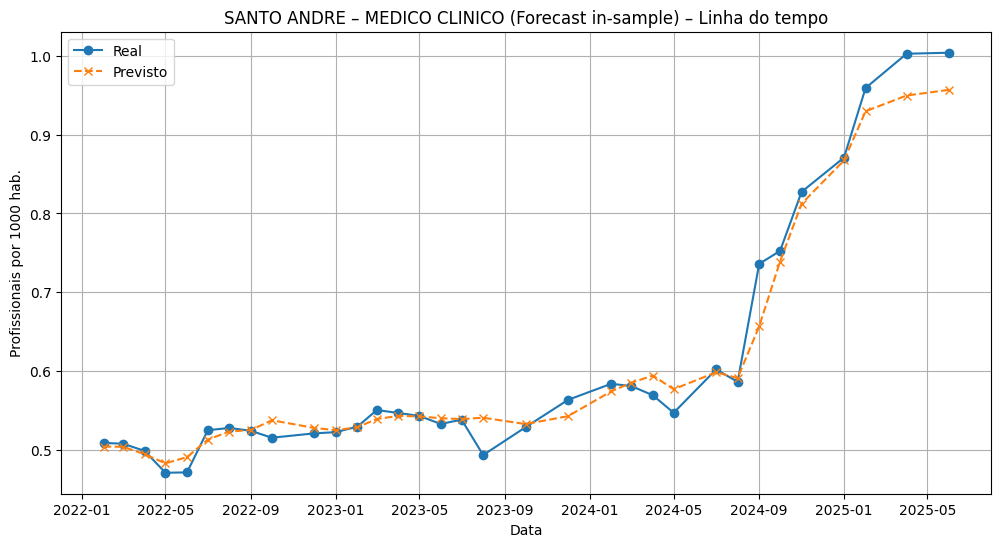

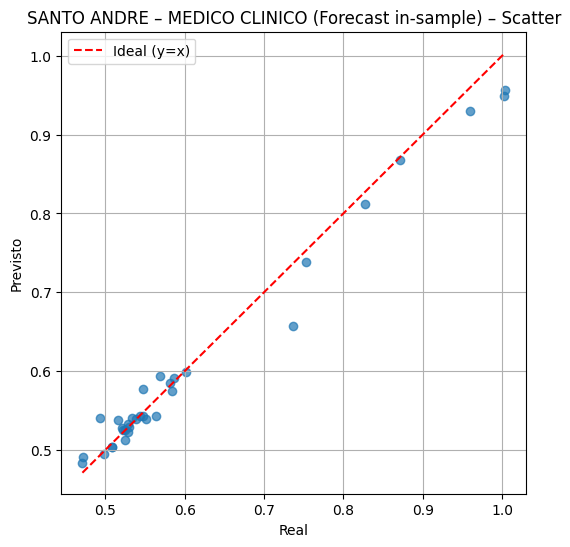

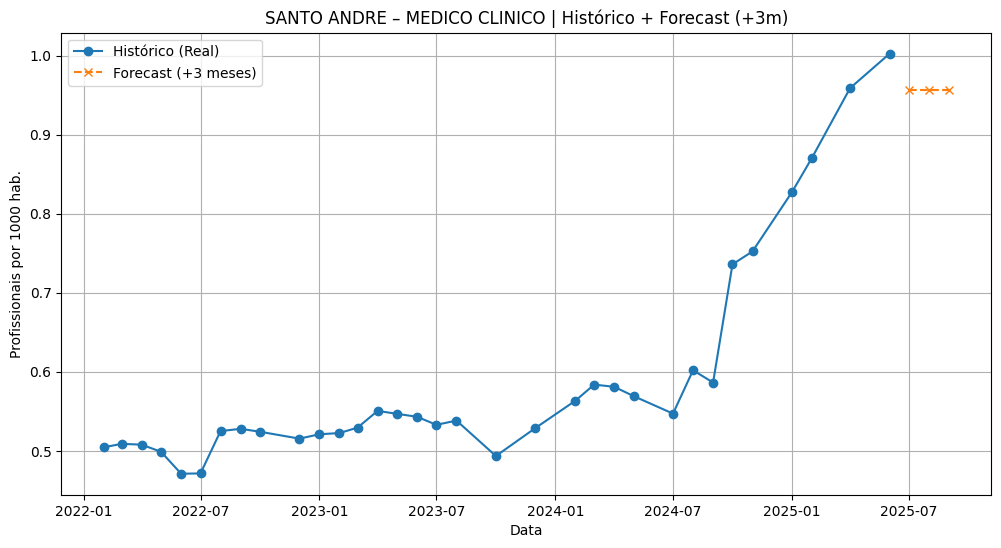


=== FORECASTING: Próximos 3 meses ===
        date  previsto
0 2025-07-01  0.956674
1 2025-08-01  0.956674
2 2025-09-01  0.956674


In [389]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# regressão para prever target_next_month (valor contínuo)
df_reg = df_model.dropna(subset=features + ["target_next_month"]).copy()
X_reg = df_reg[features]
y_reg = df_reg["target_next_month"]

Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg = RandomForestRegressor(random_state=42)
reg.fit(Xr_tr, yr_tr)

yr_pred = reg.predict(Xr_te)

rmse = root_mean_squared_error(yr_te, yr_pred)
mae = mean_absolute_error(yr_te, yr_pred)
r2 = r2_score(yr_te, yr_pred)

print("\n=== FORECASTING: Avaliação ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# 1 linha para plotar histórico vs previsto (in-sample)
plot_real_vs_previsto(
    df=df_reg,
    features=features,
    model=reg,
    target_col="target_next_month",
    title=f"{MUNICIPIO} – {ESPECIALIDADE} (Forecast in-sample)"
)

# Forecast iterativo N meses à frente + plot
forecast_df = forecast_n_months_from_model_and_plot(
    df=df_reg,
    features=features,
    model=reg,
    n_months=3,
    title=f"{MUNICIPIO} – {ESPECIALIDADE} | Histórico + Forecast (+3m)"
)
print("\n=== FORECASTING: Próximos 3 meses ===")
print(forecast_df)
# =====================================================================


# Regressão Linear

=== LINEAR (in-sample temporal holdout) ===
MAE : 0.0324
RMSE: 0.0342
R²  : 0.6002


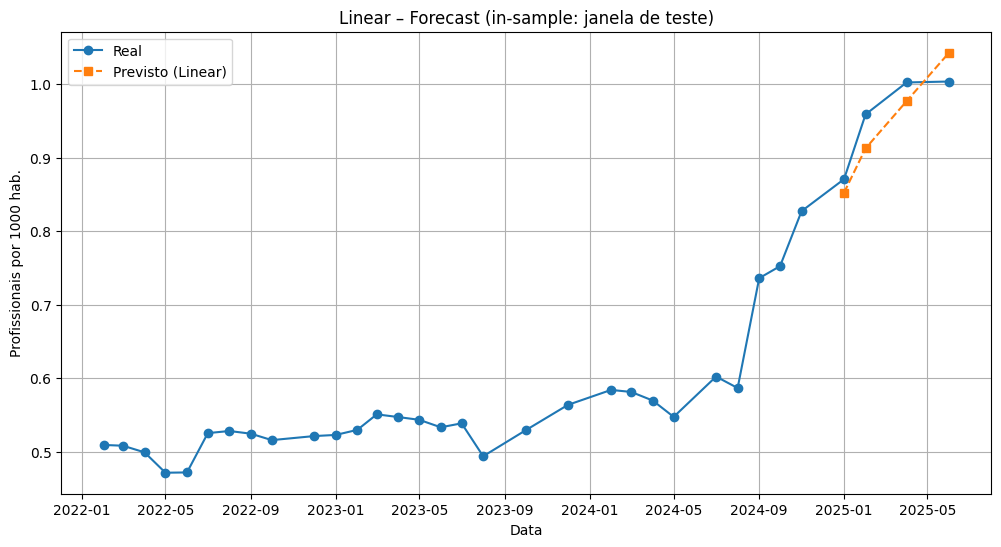

In [386]:
# ===================== CMD A — LINEAR (IN-SAMPLE) =====================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# 1) dataset para regressão (histórico com target_next_month)
df_linear = df_model.dropna(subset=features + ["target_next_month"]).copy()
df_linear = df_linear.sort_values("date").reset_index(drop=True)

# 2) índice temporal explícito
df_linear["time_index"] = df_linear.index + 1
features_lr = features + ["time_index"]

X = df_linear[features_lr]
y = df_linear["target_next_month"]

# 3) holdout temporal (ex.: 90% treino, 10% teste)
train_size = int(len(df_linear) * 0.9)
X_tr, X_te = X.iloc[:train_size], X.iloc[train_size:]
y_tr, y_te = y.iloc[:train_size], y.iloc[train_size:]

# 4) treinar e avaliar
lr = LinearRegression()
lr.fit(X_tr, y_tr)

y_pred = lr.predict(X_te)
mae = mean_absolute_error(y_te, y_pred)
rmse = root_mean_squared_error(y_te, y_pred)
r2 = r2_score(y_te, y_pred)

print("=== LINEAR (in-sample temporal holdout) ===")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

# 5) plot real vs previsto (apenas janela de teste)
plt.figure(figsize=(12,6))
plt.plot(df_linear["date"], y, marker="o", label="Real")
plt.plot(df_linear["date"].iloc[train_size:], y_pred, "s--", label="Previsto (Linear)")
plt.xlabel("Data"); plt.ylabel("Profissionais por 1000 hab.")
plt.title("Linear – Forecast (in-sample: janela de teste)")
plt.legend(); plt.grid(True); plt.show()
# =====================================================================



=== LINEAR (out-of-sample +3 meses) ===
        date  linear_forecast
0 2025-07-01         1.072150
1 2025-08-01         1.139651
2 2025-09-01         1.203289


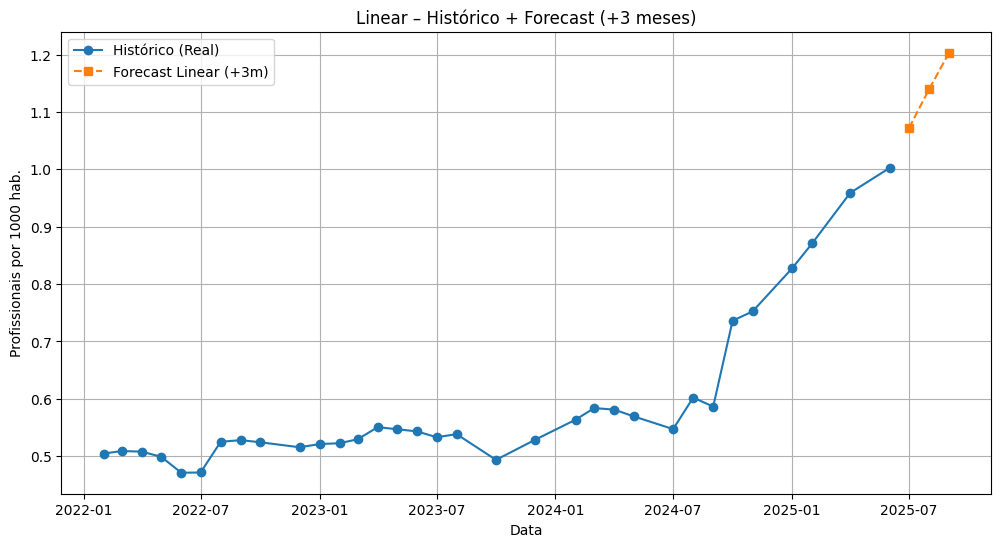

In [387]:
# ===================== CMD B — LINEAR (OUT-OF-SAMPLE +3M) =====================
import pandas as pd
import matplotlib.pyplot as plt

def linear_forecast_next_n_months(df_hist, features, lr_model, n_months=3,
                                  date_col="date", pop_col="POPULACAO_MENSAL",
                                  growth_col="GROWTH_PCT", real_col="PROFISSIONAIS_POR_1000"):
    """
    Previsão iterativa com Regressão Linear usando time_index.
    Usa o último mês REAL como base e projeta N meses à frente.
    Retorna DataFrame com [date, linear_forecast].
    """
    dfh = df_hist.sort_values(date_col).reset_index(drop=True).copy()
    # garantir time_index alinhado ao histórico real
    dfh["time_index"] = dfh.index + 1

    last_date = dfh[date_col].iloc[-1]
    last_pop  = dfh[pop_col].iloc[-1]
    growth_mean = dfh[growth_col].tail(3).mean()
    growth_mean = 0.0 if pd.isna(growth_mean) else float(growth_mean)

    # histórico de alvo real para lag/rolling
    history = dfh[real_col].tolist()
    results = []

    # lista completa de features da Linear
    features_lr = features + ["time_index"]

    for i in range(1, n_months + 1):
        next_date = last_date + pd.offsets.MonthBegin(i)
        next_pop  = int(last_pop * (1 + growth_mean))
        lag1      = history[-1]
        rolling3  = pd.Series(history[-3:]).mean()
        time_idx  = len(dfh) + i  # continua o índice temporal

        # construir features do próximo mês
        next_feat = {
            pop_col: next_pop,
            growth_col: growth_mean,
            "lag1": float(lag1),
            "rolling3": float(rolling3),
            "time_index": time_idx,
        }
        # herdar dummies/colunas adicionais usadas no treino
        last_row = dfh.iloc[-1]
        for col in features:
            if col not in next_feat:
                next_feat[col] = last_row.get(col, 0)

        X_next = pd.DataFrame([next_feat], columns=features_lr)
        y_next = float(lr_model.predict(X_next)[0])

        results.append({"date": next_date, "linear_forecast": y_next})

        # atualizar estado para próxima iteração
        history.append(y_next)
        last_pop = next_pop

    return pd.DataFrame(results)

# 1) usar o mesmo df_model (filtrado) e o modelo 'lr' treinado no CMD A
df_hist = df_model.dropna(subset=features + ["target_next_month"]).copy().sort_values("date")
df_hist = df_hist.reset_index(drop=True)

# 2) gerar forecast +3m
forecast_lin = linear_forecast_next_n_months(df_hist, features, lr, n_months=3)

print("\n=== LINEAR (out-of-sample +3 meses) ===")
print(forecast_lin)

# 3) plot histórico real + previsão linear futura
plt.figure(figsize=(12,6))
plt.plot(df_hist["date"], df_hist["PROFISSIONAIS_POR_1000"], marker="o", label="Histórico (Real)")
plt.plot(forecast_lin["date"], forecast_lin["linear_forecast"], "s--", label="Forecast Linear (+3m)")
plt.xlabel("Data"); plt.ylabel("Profissionais por 1000 hab.")
plt.title("Linear – Histórico + Forecast (+3 meses)")
plt.legend(); plt.grid(True); plt.show()
# =====================================================================


# Escolha de Modelos

## 1. Definir o que significa “melhor modelo”

Antes de rodar algoritmos, é preciso definir **critério de escolha**.  
No seu caso, existem dois tipos de problema:

### Classificação (déficit ou não)
- **Métricas**: `F1-score`, `Recall`, `ROC-AUC`.  
- **Justificativa**: em saúde, o mais importante é **minimizar falsos negativos** (não deixar passar uma cidade que entrará em déficit).  
- **Prioridade**: provavelmente você vai priorizar **Recall**, mesmo que isso aumente falsos positivos.

### Forecasting (valor contínuo)
- **Métricas**: `MAE`, `RMSE`, `R²`.  
- **Justificativa**:
  - `RMSE` → bom para punir **erros grandes** (importante em cidades grandes).  
  - `MAE` → mostra o **erro médio típico**, menos afetado por extremos (bom para cidades pequenas).  
  - `R²` → resume a proporção da variação explicada.  
- **Uso**: você pode (e deve) reportar mais de uma métrica.

---

## 2. Comparar modelos simples vs complexos

No forecasting, testamos dois modelos:

### Random Forest (RF)
- **Vantagem**: captura relações não-lineares.  
- **Limitação**: não extrapola tendência (tende a ficar “flat”).  
- **Indicado**: quando a série oscila sem tendência clara.

### Regressão Linear com `time_index`
- **Vantagem**: é explicável, mostra coeficiente de tendência.  
- **Limitação**: força uma tendência linear (não capta curvas ou sazonalidade).  
- **Indicado**: quando existe uma **tendência estável de crescimento/queda**.

---

## 3. Como escolher na prática

O caminho clássico (e aceito em TCCs):

1. **Defina as métricas**  
   - Exemplo: `MAE` e `RMSE` para forecasting, `Recall` e `ROC-AUC` para classificação.

2. **Treine e compare os modelos** na **mesma base temporal** (treino no passado, teste no futuro).

3. **Mostre uma tabela comparativa**:

| Modelo              | MAE  | RMSE | R²   |
|---------------------|------|------|------|
| Random Forest       | 0.45 | 0.60 | 0.82 |
| Linear (`time_index`)| 0.50 | 0.58 | 0.85 |

4. **Interprete**  
   - Mesmo que os números sejam próximos, cada modelo tem pontos fortes diferentes.

5. **Escolha com justificativa**  
   - Se o objetivo for **explicabilidade para gestores de saúde** → Linear pode ser melhor.  
   - Se for **acurácia em curto prazo** → Random Forest pode levar vantagem.  
   - Você pode até defender usar **os dois**: Linear para interpretar tendência, RF para previsões pontuais.

---

## 4. Frase pronta para o TCC

> *“Foram testados dois modelos de previsão: Random Forest e Regressão Linear com índice temporal. A escolha final não se baseou apenas nas métricas de erro (MAE, RMSE, R²), mas também na capacidade de cada modelo capturar características do problema. A Random Forest apresentou melhor ajuste em séries com oscilações curtas, mas não conseguiu extrapolar tendências. Já a Regressão Linear, apesar de simplificada, foi mais adequada para evidenciar a tendência de crescimento/queda no longo prazo, característica essencial para apoiar gestores de saúde na tomada de decisão. Assim, a escolha entre os modelos depende do objetivo: maior acurácia no curto prazo (RF) ou maior interpretabilidade e extrapolação de tendência (Linear).”*
